In [1]:
from multigrids import TemporalGrid, TemporalMultiGrid
import joblib
import sys
import os
sys.path.insert(0, os.path.abspath('../forestpy/forestpy'))

import forest
from importlib import reload
reload(forest)
import random_forest_tools as tools
reload(tools)

import matplotlib.pyplot as plt

import numpy as np

storage = {} # global storage dict



In [23]:

def evaulte_model_statistically(rf_model_file, features, labels, d_name):
    """
    """
    
    if type(rf_model_file) is str:
        clf = joblib.load(rf_model_file)
    else: 
        clf = rf_model_file
        
    ov = clf.verbose
    clf.verbose = 0 
    
    if d_name in storage:
        feats, labels_true = storage[d_name]
    else:
        feats, labels_true =  forest.format_data(features,labels)
        storage[d_name] = feats, labels_true

    
    labels_predicted = clf.predict(feats.T)

    r2 = clf.score(feats.T, labels_true)
    
    diff = labels_predicted - labels_true

    stats = {
        'min diff': np.nanmin(diff), 
        'max diff': np.nanmax(diff),
        'mean diff': np.nanmean(diff),
        'abs mean diff': np.nanmean(np.abs(diff)),
        'max abs diff': np.nanmax(np.abs(diff)),
        'min abs diff': np.nanmin(np.abs(diff)),
        'min predict':np.nanmin(labels_predicted),
        'max predict':np.nanmax(labels_predicted), 
        'r^2': r2
    }
    clf.verbose = ov
    return stats

def evaulte_model_pictorially(model_file, om,training_data, year, model_name = '' , dmin=-50, dmax=50, save=False, path='./',aoi = 'aoi-unknown'):
    """
    """
    from matplotlib import rcParams
    rcParams["font.family"] = "serif"
    rcParams['font.serif'] = ['Times']
    rcParams['font.size'] = 14
    rcParams['figure.figsize'] = (10.0, 8.0)
    
    mask = training_data.config['mask']
#     import pprint
    if type(model_file) is str:
        clf = joblib.load(model_file)
    else: 
        clf = model_file
        
    ov = clf.verbose
    clf.verbose = 0
    new = tools.apply_model_to_year(clf, training_data, year, mask)


    tools.to_figure(om[year] ,os.path.join(path, aoi + '-om-' + str(year) + '.png'), 'Climate Priming Model (Training Labels) ' + str(year),cmap = 'coolwarm', vmin=-100,vmax=100, save=save)
    tools.to_figure(new , os.path.join(path, aoi + '-'+model_name.replace(' ','-').lower()+'-' + str(year) + '.png'),model_name + ' '+ str(year),cmap = 'coolwarm', vmin=-100,vmax=100, save=save)



    
    diff = (new -om[year])
    tools.to_figure(diff , os.path.join(path, aoi + '-'+model_name.replace(' ','-').lower()+'-error-' + str(year) + '.png'),  model_name+' Error ' + str(year),cmap = 'coolwarm', save=save, vmin=dmin, vmax=dmax)

    clf.verbose = ov
    return clf

In [3]:
sp_labels = TemporalGrid('/Users/rwspicer/Desktop/data/V1/thermokarst/initiation-regions/SP/v1/PDM-5var/without_predisp/multigrid/SP-TKI-PDM5.yml')
acp_labels = TemporalGrid('/Users/rwspicer/Desktop/data/V1/thermokarst/initiation-regions/ACP/v4/PDM-5var/without_predisp/multigrid/ACP-TKI-PDM5.yml')


In [4]:
acp_no_geo_model = joblib.load('../sensitivity-analysis/ACP/no-geolocation_rfm_e50_md100_mfAUTO_mln50000_msl8_mss5_tdp.joblib')
sp_no_geo_model = joblib.load('../sensitivity-analysis/SP/no-geolocation_rfm_e50_md100_mfAUTO_mln50000_msl8_mss5_tdp.joblib')

In [5]:
acp_base_model = joblib.load('../sensitivity-analysis/ACP/acp_baseline.joblib')
sp_base_model = joblib.load('../sensitivity-analysis/SP/SP_baseline.joblib')

In [6]:
acp_base_feat = TemporalMultiGrid(
    '/Volumes/toshi-stati/data/V1/master-project/training/ACP/v2/baseline/multigrid/ACP-training-base.yml'
)
sp_base_feat = TemporalMultiGrid(
    '/Volumes/toshi-stati/data/V1/master-project/training/SP/v1/baseline/multigrid/SP-rf-training-set.yml'
)

mask = np.logical_not(np.isnan(sp_base_feat['fdd', 1950]))
for k in sp_base_feat.config['grid_name_map']:
    mask = np.logical_and(mask, np.logical_not(np.isnan(sp_base_feat[k, 1950]) ))
mask = np.logical_and(mask, np.logical_not(np.isnan(sp_labels[1950]) ))

sp_base_feat.config['mask'] = mask



In [7]:


acp_no_geo_feat = TemporalMultiGrid(
    '/Volumes/toshi-stati/data/V1/master-project/training/ACP/v2/no-geolocation/multigrid/no-geolocation.yml'
)
sp_no_geo_feat = TemporalMultiGrid(
    '/Volumes/toshi-stati/data/V1/master-project/training/SP/v1/no-geolocation/multigrid/no-geolocation.yml'
)

mask = np.logical_not(np.isnan(sp_no_geo_feat['fdd', 1950]))
for k in sp_no_geo_feat.config['grid_name_map']:
    mask = np.logical_and(mask, np.logical_not(np.isnan(sp_no_geo_feat[k, 1950]) ))
mask = np.logical_and(mask, np.logical_not(np.isnan(sp_labels[1950]) ))

sp_no_geo_feat.config['mask'] = mask

In [8]:
acp_for_sp_no_geo_grades = evaulte_model_statistically(sp_no_geo_model, acp_no_geo_feat, acp_labels, 'ACP_DATA')

In [9]:
acp_for_sp_no_geo_grades

{'min diff': -89.17026259751246,
 'max diff': 96.59602197194567,
 'mean diff': -8.395802236004648,
 'abs mean diff': 13.45998464424299,
 'max abs diff': 96.59602197194567,
 'min abs diff': 1.7934079643566747e-07,
 'min predict': -34.70326649068189,
 'max predict': 80.65080345805922,
 'r^2': -0.7306946316084179}

In [10]:
sp_for_acp_no_geo_grades = evaulte_model_statistically(acp_no_geo_model, sp_no_geo_feat, sp_labels, 'SP_DATA')

In [11]:
sp_for_acp_no_geo_grades

{'min diff': -94.91314320358501,
 'max diff': 71.60551493034347,
 'mean diff': 3.639498865370008,
 'abs mean diff': 14.310084725965687,
 'max abs diff': 94.91314320358501,
 'min abs diff': 7.609592646007357e-06,
 'min predict': -35.966578528598006,
 'max predict': 70.50582618563519,
 'r^2': -0.34480923859901247}

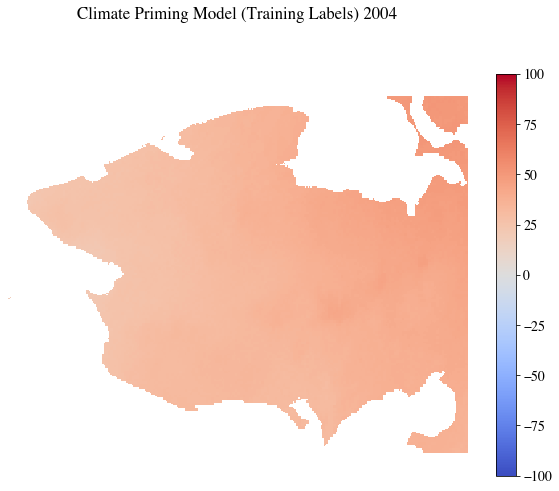

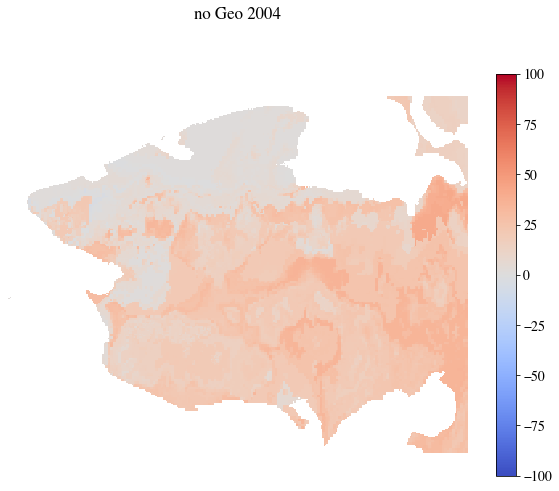

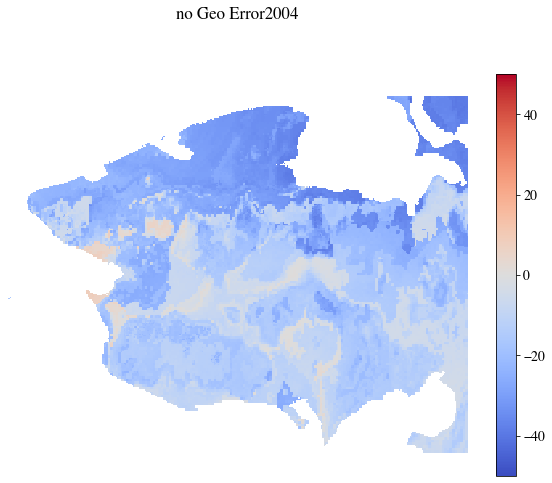

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=50000,
           min_impurity_decrease=0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=5,
           min_weight_fraction_leaf=0, n_estimators=50, n_jobs=12,
           oob_score=False, random_state=42, verbose=2, warm_start=False)

In [10]:

evaulte_model_pictorially(acp_no_geo_model,sp_labels, sp_no_geo_feat, 2004, 'no Geo')


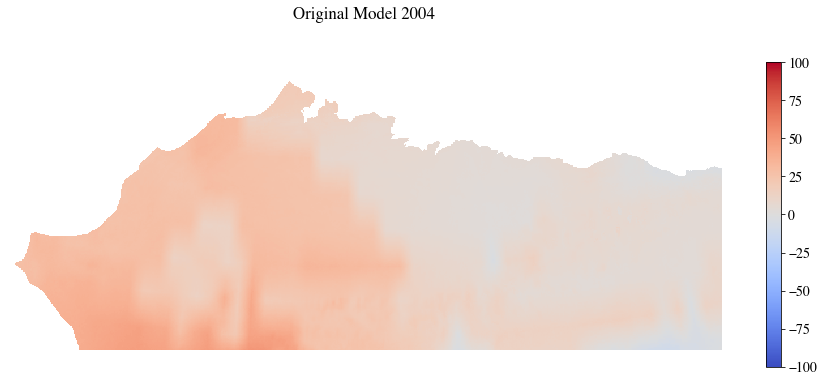

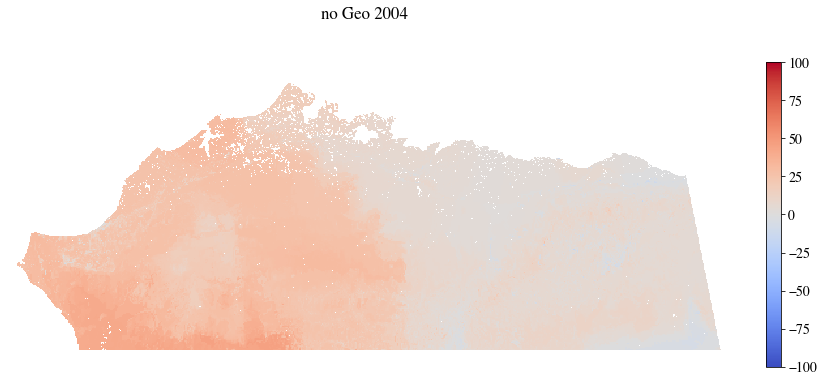

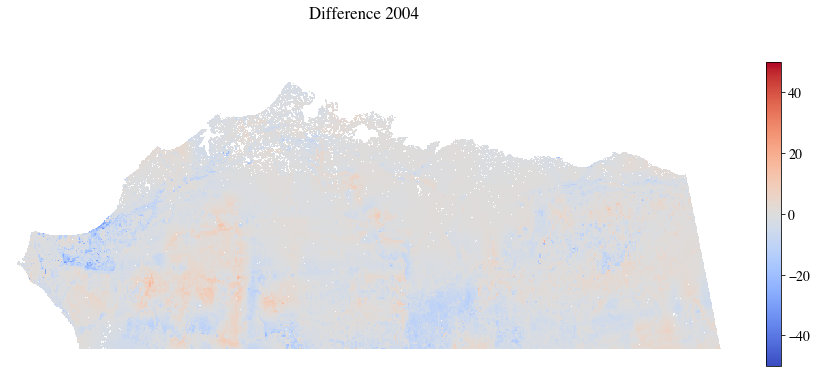

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=50000,
           min_impurity_decrease=0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=5,
           min_weight_fraction_leaf=0, n_estimators=50, n_jobs=12,
           oob_score=False, random_state=42, verbose=2, warm_start=False)

In [12]:
evaulte_model_pictorially(acp_no_geo_model,acp_labels, acp_no_geo_feat, 2004, 'no Geo')


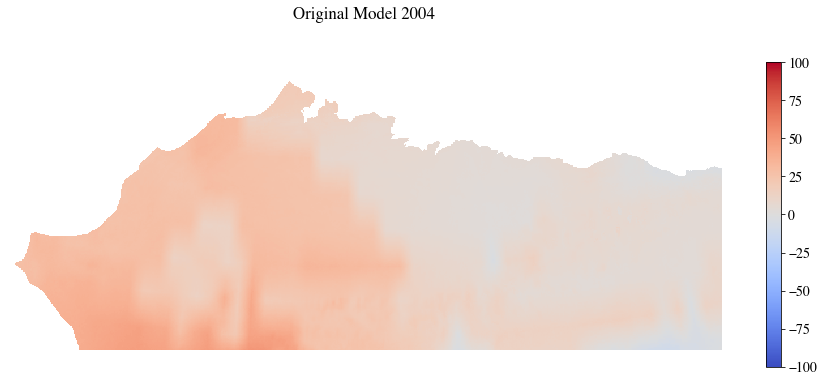

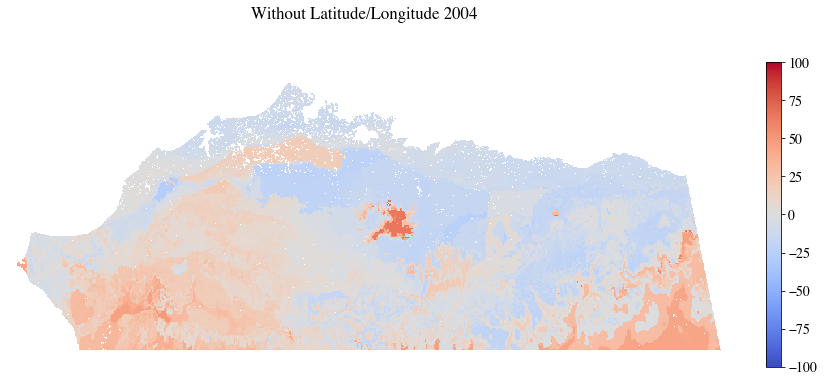

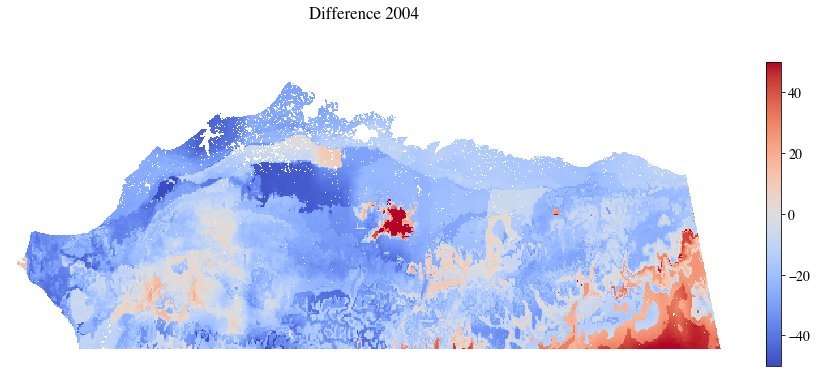

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=50000,
           min_impurity_decrease=0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=5,
           min_weight_fraction_leaf=0, n_estimators=50, n_jobs=12,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [64]:
evaulte_model_pictorially(sp_no_geo_model,acp_labels, acp_no_geo_feat, 2004, 'Without Latitude/Longitude')

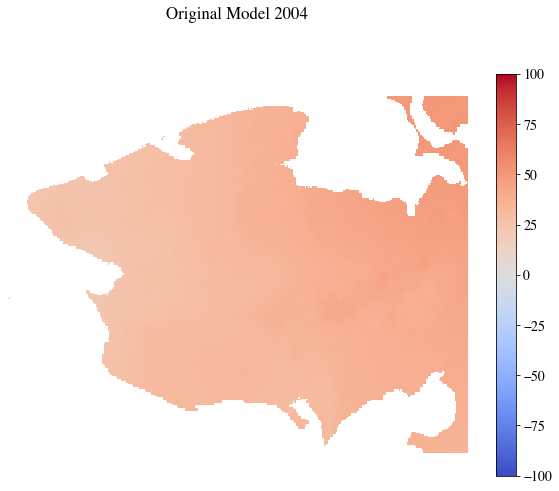

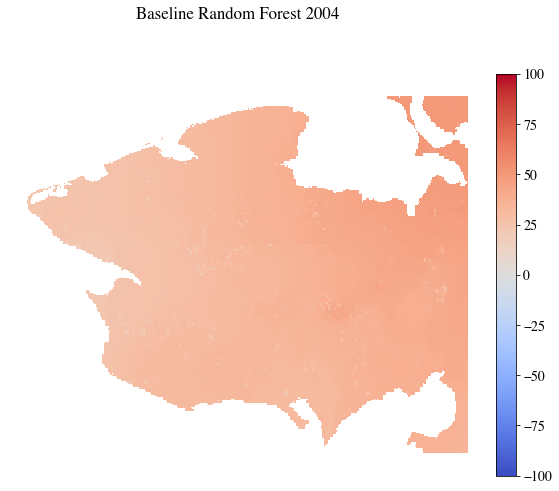

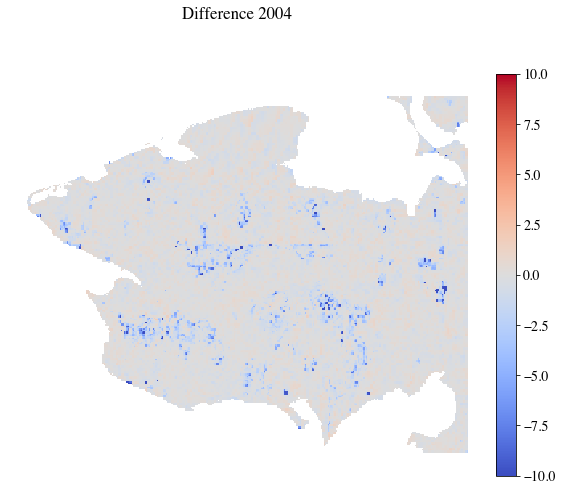

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=50000,
           min_impurity_decrease=0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=5,
           min_weight_fraction_leaf=0, n_estimators=50, n_jobs=12,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [78]:

evaulte_model_pictorially(sp_base_model,sp_labels, sp_base_feat, 2004, 'Baseline Random Forest' ,dmin=-10,dmax=10)

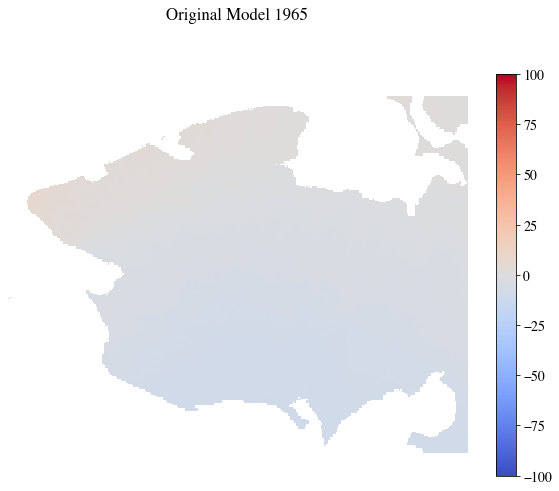

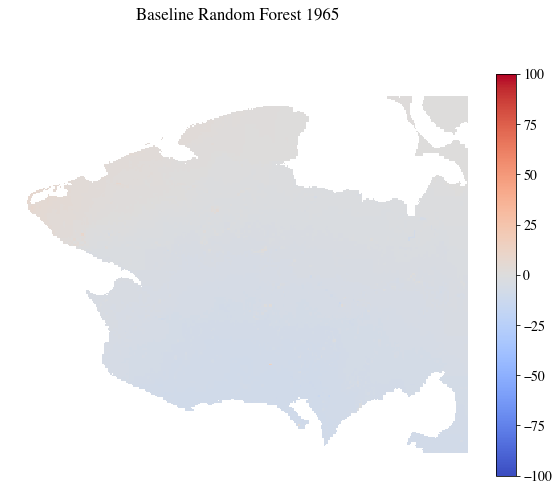

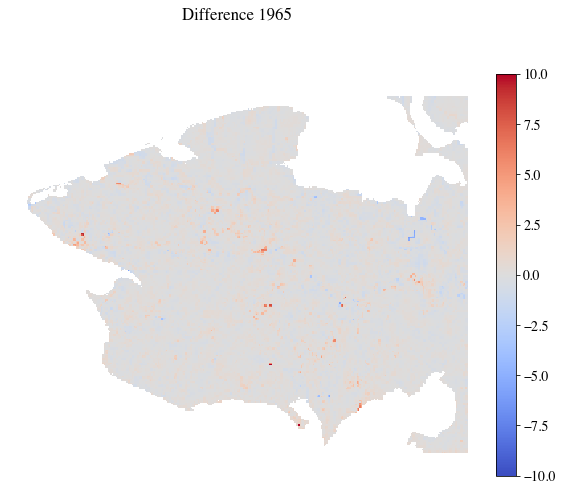

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=50000,
           min_impurity_decrease=0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=5,
           min_weight_fraction_leaf=0, n_estimators=50, n_jobs=12,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [79]:
evaulte_model_pictorially(sp_base_model,sp_labels, sp_base_feat, 1965, 'Baseline Random Forest',dmin=-10,dmax=10)

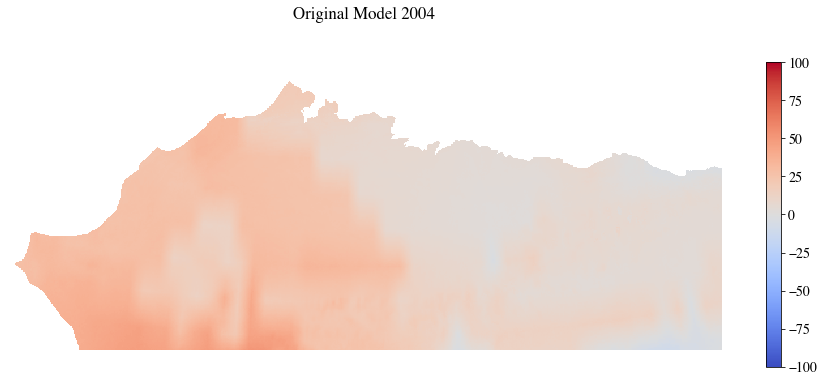

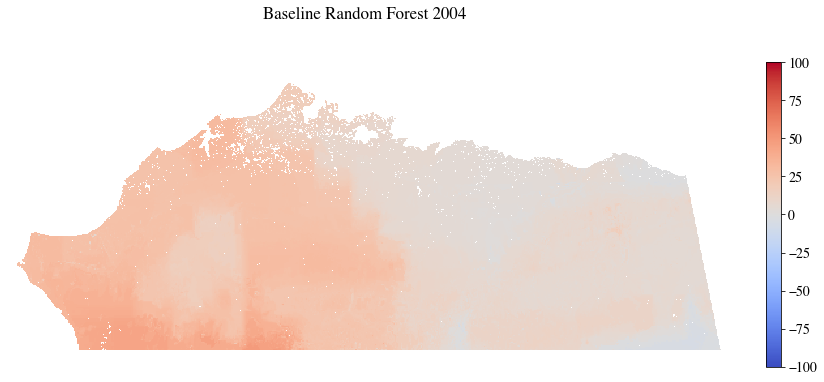

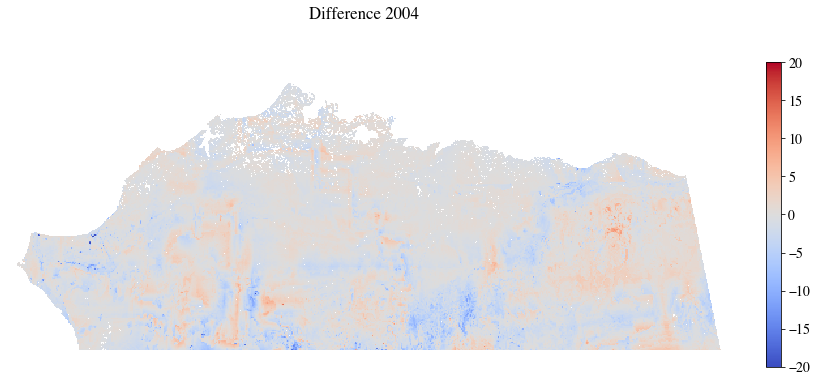

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=50000,
           min_impurity_decrease=0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=5,
           min_weight_fraction_leaf=0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=42, verbose=2, warm_start=False)

In [81]:
evaulte_model_pictorially(acp_base_model,acp_labels, acp_base_feat, 2004, 'Baseline Random Forest' ,dmin=-20,dmax=20)

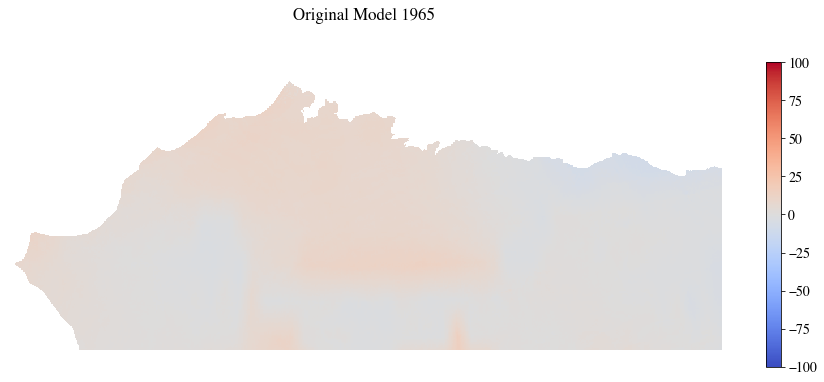

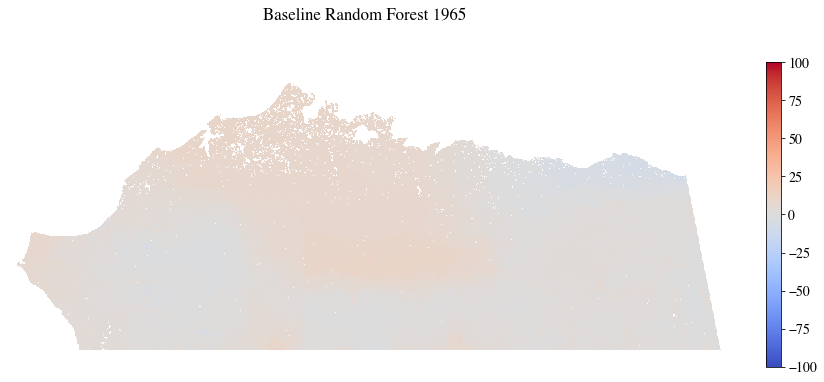

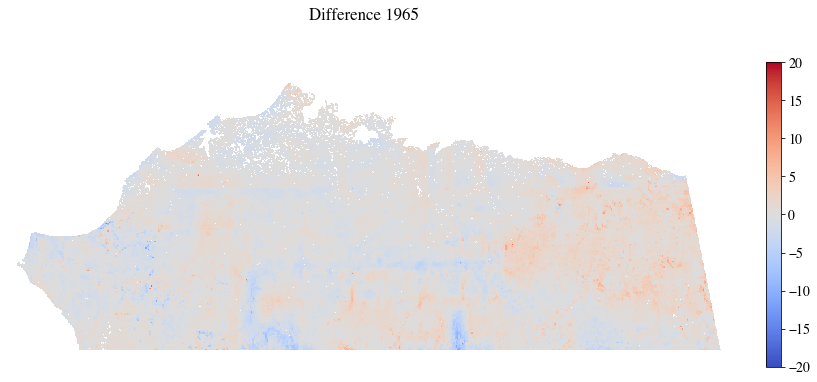

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=50000,
           min_impurity_decrease=0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=5,
           min_weight_fraction_leaf=0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=42, verbose=2, warm_start=False)

In [83]:
evaulte_model_pictorially(acp_base_model,acp_labels, acp_base_feat, 1965, 'Baseline Random Forest' ,dmin=-20,dmax=20)

In [24]:
# model_file, om,training_data, year, model_name = '' , dmin=-50, dmax=50, save=False, path='./',aoi = 'aoi-unknown'):


def save_all(current_model ,original_model, training_data , model_name, dmin,dmax, save, path, aoi):
    for year in range(1901,2016):
        evaulte_model_pictorially(current_model ,original_model, training_data , year, model_name, dmin,dmax, save, path, aoi)



In [26]:
## SP baseline
current_model = sp_base_model
original_model = sp_labels
training_data = sp_base_feat
# year =2004
model_name = 'Random Forest - Baseline SP trained'
dmin=-20
dmax=20
save = True
path = '../figures/baseline/'
aoi = 'SP'


save_all(current_model ,original_model, training_data , model_name, dmin,dmax, save, path, aoi)

In [28]:

## SP NO GEO
current_model = sp_no_geo_model
original_model = sp_labels
training_data = sp_no_geo_feat
# year =2004
model_name = 'Random Forest - Removed Location'
dmin=-20
dmax=20
save = True
path = '../figures/no-geo/'
aoi = 'SP'


save_all(current_model ,original_model, training_data , model_name, dmin,dmax, save, path, aoi)

In [29]:
## ACP baseline
current_model = acp_base_model
original_model = acp_labels
training_data = acp_base_feat
# year =2004
model_name = 'Random Forest - Baseline ACP trained'
dmin=-20
dmax=20
save = True
path = '../figures/baseline/'
aoi = 'ACP'


save_all(current_model ,original_model, training_data , model_name, dmin,dmax, save, path, aoi)

In [30]:
## ACP NO GEO
current_model = acp_no_geo_model
original_model = acp_labels
training_data = acp_no_geo_feat
# year =2004
model_name = 'Random Forest - Removed Location'
dmin=-20
dmax=20
save = True
path = '../figures/no-geo/'
aoi = 'ACP'


save_all(current_model ,original_model, training_data , model_name, dmin,dmax, save, path, aoi)

In [31]:
## SP baseline on acp
current_model = sp_base_model
original_model = acp_labels
training_data = acp_base_feat
# year =2004
model_name = 'Random Forest - Baseline SP trained'
dmin=-20
dmax=20
save = True
path = '../figures/baseline/'
aoi = 'ACP'


save_all(current_model ,original_model, training_data , model_name, dmin,dmax, save, path, aoi)

In [32]:
## ACP baseline on SP
current_model = acp_base_model
original_model = sp_labels
training_data = sp_base_feat
# year =2004
model_name = 'Random Forest - Baseline ACP trained'
dmin=-20
dmax=20
save = True
path = '../figures/baseline/'
aoi = 'SP'


save_all(current_model ,original_model, training_data , model_name, dmin,dmax, save, path, aoi)

In [33]:
## SP NO GEO on acp
current_model = sp_no_geo_model
original_model = acp_labels
training_data = acp_no_geo_feat
# year =2004
model_name = 'Random Forest - Removed Location'
dmin=-20
dmax=20
save = True
path = '../figures/no-geo/'
aoi = 'ACP'


save_all(current_model ,original_model, training_data , model_name, dmin,dmax, save, path, aoi)

In [34]:
## ACP NO GEO on sp
current_model = acp_no_geo_model
original_model = sp_labels
training_data = sp_no_geo_feat
# year =2004
model_name = 'Random Forest - Removed Location'
dmin=-20
dmax=20
save = True
path = '../figures/no-geo/'
aoi = 'SP'


save_all(current_model ,original_model, training_data , model_name, dmin,dmax, save, path, aoi)